<a href="https://colab.research.google.com/github/Vakhranev/Heritage/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BF%D0%BE%D0%B2%D1%82%D0%BE%D1%80%D0%BE%D0%B2%20%D0%BA%D0%BE%D0%BB%D0%BB%D0%BE%D0%BA%D0%B0%D1%86%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import json
import numpy as np

# Функции для обработки текста
def split_into_windows(text, num_windows=10):
    tokens = text.split()
    window_size = max(1, len(tokens) // num_windows)
    return [tokens[i * window_size:(i + 1) * window_size] for i in range(num_windows)]

def count_repeated_collocations(windows):
    seen_collocations = set()
    repeated_counts = []

    for window in windows:
        window_bigrams = [f"{window[i]} {window[i+1]}" for i in range(len(window) - 1)]
        repeated_count = sum(1 for bigram in window_bigrams if bigram in seen_collocations)
        repeated_counts.append(repeated_count)
        seen_collocations.update(window_bigrams)
    return repeated_counts

# Чтение данных
with open('america_texts.json', 'r', encoding='utf-8') as f:
    america_texts = json.load(f)

with open('lib_texts.json', 'r', encoding='utf-8') as f:
    lib_texts = json.load(f)

with open('files_by_levels.txt', 'r', encoding='utf-8') as f:
    files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
    current_level = None
    for line in f:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line and current_level:
            files_by_levels[current_level].append(line)

# Анализ данных
def analyze_by_level(files, data, num_windows=10):
    all_repeated = np.zeros(num_windows)
    count = 0

    for file in files:
        if file in data:
            text = data[file]['text']
            windows = split_into_windows(text, num_windows)
            repeated = count_repeated_collocations(windows)
            all_repeated += np.array(repeated)
            count += 1

    return all_repeated / max(count, 1)

# Усреднение по уровням и художественным текстам
num_windows = 10
repeated_results = {}

for level, files in files_by_levels.items():
    repeated_results[level] = analyze_by_level(files, america_texts, num_windows)

lib_repeated = analyze_by_level(lib_texts.keys(), lib_texts, num_windows)

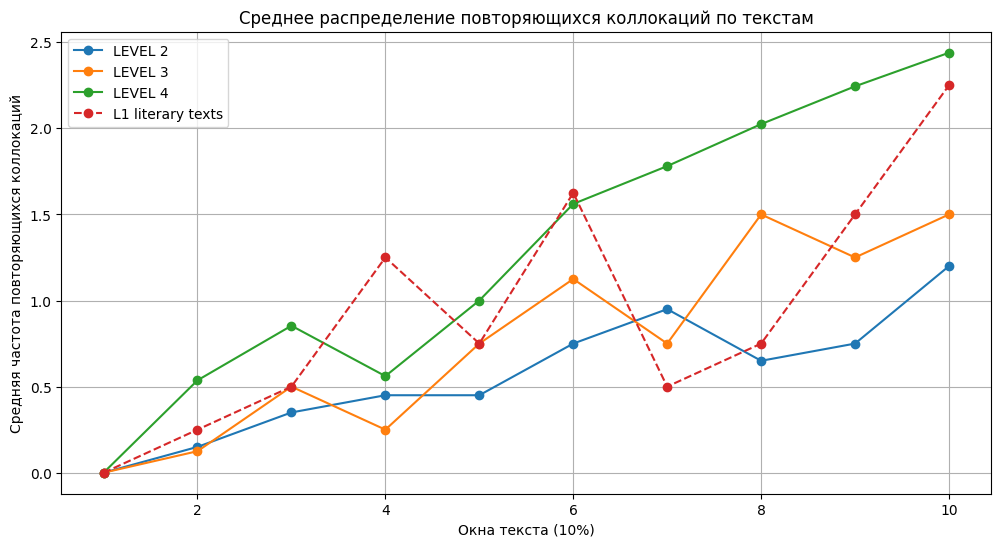

In [9]:
import matplotlib.pyplot as plt

# Построение графика
plt.figure(figsize=(12, 6))

for level, results in repeated_results.items():
    plt.plot(range(1, num_windows + 1), results, marker='o', label=f"{level}")

plt.plot(range(1, num_windows + 1), lib_repeated, marker='o', label='L1 literary texts', linestyle='--')

plt.xlabel('Окна текста (10%)')
plt.ylabel('Средняя частота повторяющихся коллокаций')
plt.title('Среднее распределение повторяющихся коллокаций по текстам')
plt.legend()
plt.grid()
plt.show()


In [1]:
import json
import numpy as np

# Функция для вычисления длины окна в биграммах
def calculate_bigram_window_size(text, num_windows=10):
    tokens = text.split()  # Разделение текста на токены
    window_size = len(tokens) // num_windows  # Длина окна в токенах
    bigram_window_size = window_size - 1  # Количество биграмм
    return bigram_window_size, len(tokens)

# Функция для подсчета повторяющихся коллокаций в окне
def count_repeated_collocations(windows):
    seen_collocations = set()
    repeated_counts = []

    for window in windows:
        window_bigrams = [f"{window[i]} {window[i+1]}" for i in range(len(window) - 1)]
        repeated_count = sum(1 for bigram in window_bigrams if bigram in seen_collocations)
        repeated_counts.append(repeated_count)
        seen_collocations.update(window_bigrams)

    return repeated_counts

# Чтение данных
with open('america_texts.json', 'r', encoding='utf-8') as f:
    america_texts = json.load(f)

with open('lib_texts.json', 'r', encoding='utf-8') as f:
    lib_texts = json.load(f)

with open('files_by_levels.txt', 'r', encoding='utf-8') as f:
    files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
    current_level = None
    for line in f:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line and current_level:
            files_by_levels[current_level].append(line)

# Функция для анализа текста по уровням
def analyze_by_level(files, data, num_windows=10):
    level_bigram_size = []
    level_repeated_percentage = {i: [] for i in range(1, num_windows + 1)}

    for file in files:
        if file in data:
            text = data[file]['text']
            bigram_window_size, total_tokens = calculate_bigram_window_size(text, num_windows)
            windows = [text.split()[i*bigram_window_size:(i+1)*bigram_window_size] for i in range(len(text.split()) // bigram_window_size)]
            repeated_collocations = count_repeated_collocations(windows)

            # Считаем процент повторяющихся коллокаций для каждого окна
            total_bigrams = bigram_window_size * len(windows)
            for i in range(num_windows):
                if total_bigrams > 0:
                    level_repeated_percentage[i + 1].append(repeated_collocations[i] / bigram_window_size * 100)

            level_bigram_size.append(bigram_window_size)

    # Средний размер окна и процент повторяющихся коллокаций для каждого окна
    avg_bigram_size = np.mean(level_bigram_size)
    avg_repeated_percentage = {i: np.mean(level_repeated_percentage[i]) for i in range(1, num_windows + 1)}

    return avg_bigram_size, avg_repeated_percentage

# Анализ данных по уровням и художественным текстам
num_windows = 10
levels_results = {}
lib_results = {}

for level, files in files_by_levels.items():
    avg_bigram_size, avg_repeated_percentage = analyze_by_level(files, america_texts, num_windows)
    levels_results[level] = (avg_bigram_size, avg_repeated_percentage)

lib_avg_bigram_size, lib_avg_repeated_percentage = analyze_by_level(lib_texts.keys(), lib_texts, num_windows)
lib_results = (lib_avg_bigram_size, lib_avg_repeated_percentage)

# Вывод статистики
for level, (avg_bigram_size, avg_repeated_percentage) in levels_results.items():
    print(f"{level}")
    print(f"Средний размер окна — {avg_bigram_size:.2f} коллокаций")
    for i in range(1, num_windows + 1):
        print(f"Среднее количество повторяющихся коллокаций окна №{i} — {avg_repeated_percentage[i]:.2f}%")

print("L1 literary texts")
print(f"Средний размер окна — {lib_avg_bigram_size:.2f} коллокаций")
for i in range(1, num_windows + 1):
    print(f"Среднее количество повторяющихся коллокаций окна №{i} — {lib_avg_repeated_percentage[i]:.2f}%")

LEVEL 2
Средний размер окна — 15.00 коллокаций
Среднее количество повторяющихся коллокаций окна №1 — 0.00%
Среднее количество повторяющихся коллокаций окна №2 — 0.53%
Среднее количество повторяющихся коллокаций окна №3 — 2.39%
Среднее количество повторяющихся коллокаций окна №4 — 1.43%
Среднее количество повторяющихся коллокаций окна №5 — 3.43%
Среднее количество повторяющихся коллокаций окна №6 — 4.34%
Среднее количество повторяющихся коллокаций окна №7 — 4.63%
Среднее количество повторяющихся коллокаций окна №8 — 4.64%
Среднее количество повторяющихся коллокаций окна №9 — 5.47%
Среднее количество повторяющихся коллокаций окна №10 — 4.49%
LEVEL 3
Средний размер окна — 17.62 коллокаций
Среднее количество повторяющихся коллокаций окна №1 — 0.00%
Среднее количество повторяющихся коллокаций окна №2 — 1.04%
Среднее количество повторяющихся коллокаций окна №3 — 2.06%
Среднее количество повторяющихся коллокаций окна №4 — 2.44%
Среднее количество повторяющихся коллокаций окна №5 — 2.44%
Средн